In [10]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for machine learning
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from joblib import dump,load
import shap

# Display setting for exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# Check out if the environment is the correct Anaconda one
import sys
print('environment: ',sys.executable)

# Set up directory to be the github repository
# requires git
import os
import subprocess
os.getcwd()
output = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
path = output.decode('utf-8').strip()
print('working directory: ',path)
os.chdir(path)


environment:  c:\Users\ricca\anaconda3\envs\Thesis\python.exe
working directory:  C:/Users/ricca/Documents/GitHub/Thesis-SEM-ML


In [3]:
from Source.DataPreparation.DataProcessor import DataProcessor
from Source.Classification.observed_variables_classification import GBoostClassification, LogisticRegressionClass

In [4]:
Results_XGB_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_LR_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_Random_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_Majority_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

Results_XGB_Proba_dict = {
    'eng_timeflies': [],
    'eng_enthusiastic': [],
    'eng_energy': []
}

In [5]:
montecarloiter=1

for i in range(montecarloiter):
    print(f"Starting the iteration n.{i+1}")
    processorclass=DataProcessor()
    processorclass.read_df()
    processorclass.split_data(test_size=0.3)
    processorclass.save_data()
    processorclass.process_CFA()


    for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
        print(f"Starting the iteration n.{i+1} for dimension {dimension}")

        X_train,y_train,X_test,y_test = processorclass.train_test_data_for_WEtarget(target_variable=dimension,combineseldom=True)

         # Calculate random and majority classifier accuracy
        class_counts = np.bincount(y_test)
        class_probabilities = class_counts / len(y_test)
        random_accuracy = np.sum(class_probabilities**2)
        Results_Random_dict[dimension].append(random_accuracy)
        print(f"Accuracy of a random classifier for dimension {dimension}: {random_accuracy:.4f}")
        majority_class = np.argmax(class_counts)
        majority_accuracy = class_counts[majority_class] / len(y_test)
        Results_Majority_dict[dimension].append(majority_accuracy)
        print(f"Accuracy of a majority classifier for dimension {dimension}: {majority_accuracy:.4f}")


        # XGBClassifier
        Xgboost=GBoostClassification(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
        Xgboost.train(verbosity=0,n_iter=50)
        mxgbresults = Xgboost.get_results()
        Results_XGB_dict[dimension].append((mxgbresults['accuracy'],mxgbresults['precision'],mxgbresults['recall'],mxgbresults['train_accuracy'],mxgbresults['train_precision'],mxgbresults['train_recall']))
        Results_XGB_Proba_dict[dimension].append(Xgboost.get_probas())
        print(f"Iteration {i+1} XGBoost: accuracy: {mxgbresults['accuracy']}, precision: {mxgbresults['precision']}, recall: {mxgbresults['recall']}, train_accuracy:{mxgbresults['train_accuracy']}")

        # Logistic Regression
        LRcla= LogisticRegressionClass(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
        LRcla.median_imputation()
        LRcla.train(verbosity=0)
        LRresults = LRcla.get_results()
        Results_LR_dict[dimension].append((LRresults['accuracy'],LRresults['precision'],LRresults['recall'],LRresults['train_accuracy'],LRresults['train_precision'],LRresults['train_recall']))

        print(f"Iteration {i+1} Logistic: accuracy: {LRresults['accuracy']}, precision: {LRresults['precision']}, recall: {LRresults['recall']}, train_accuracy:{LRresults['train_accuracy']}")

        print(("-------------------------------------------------"))

Starting the iteration n.1
The dataframe was loaded
A Train-Test split was performed with a test size of 0.3
Datasets were saved
Starting the CFA
Starting the iteration n.1 for dimension eng_timeflies
Values of the classes 1 and 2 were combined.
Accuracy of a random classifier for dimension eng_timeflies: 0.3173
Accuracy of a majority classifier for dimension eng_timeflies: 0.4078
Starting the XGBClassifier training
Iteration 1 XGBoost: accuracy: 0.4776536312849162, precision: 0.417978088286054, recall: 0.4776536312849162, train_accuracy:0.5359712230215827
Starting the Logistic Regression
Iteration 1 Logistic: accuracy: 0.4664804469273743, precision: 0.4616252947709066, recall: 0.4664804469273743, train_accuracy:0.5299760191846523
-------------------------------------------------
Starting the iteration n.1 for dimension eng_enthusiastic
Values of the classes 1 and 2 were combined.
Accuracy of a random classifier for dimension eng_enthusiastic: 0.3184
Accuracy of a majority classifier f

In [8]:
for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    probas = np.mean(Results_XGB_Proba_dict[dimension], axis=0)

358
358
358


In [11]:
y_bin = label_binarize(y_test, classes=np.unique(y_test))
print(y_bin)
print(y_bin.shape)

[[0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 ...
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]]
(358, 4)


[[0.16099297 0.18389907 0.30201262 0.35309532]
 [0.15779476 0.19926433 0.26960406 0.37333685]
 [0.1896233  0.27196833 0.25244385 0.28596455]
 ...
 [0.16192502 0.27365798 0.33822006 0.22619693]
 [0.23432676 0.23951258 0.27208823 0.25407243]
 [0.20182003 0.20612948 0.2796763  0.31237423]]


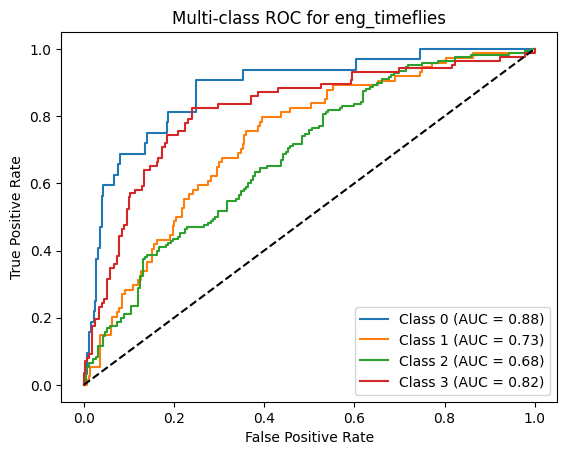

[[0.06343712 0.09916229 0.26882982 0.5685708 ]
 [0.09129418 0.10336877 0.15799846 0.64733857]
 [0.17460264 0.48278925 0.20272024 0.13988793]
 ...
 [0.11473775 0.17638963 0.3299271  0.37894556]
 [0.28616574 0.20462523 0.23701926 0.27218974]
 [0.12517476 0.19130747 0.37204227 0.31147546]]


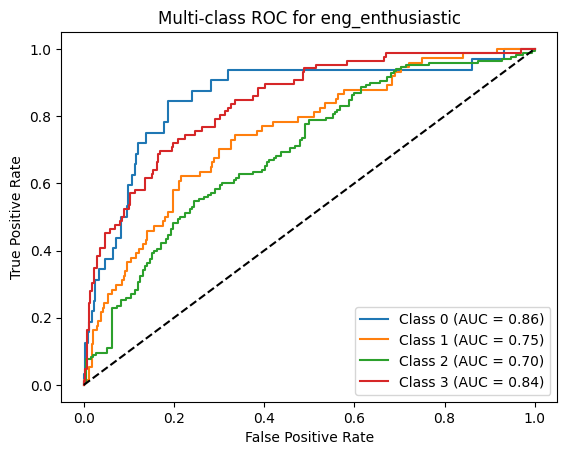

[[0.06620865 0.11360592 0.35976496 0.46042043]
 [0.10404295 0.13404159 0.3517379  0.41017762]
 [0.2188816  0.39839712 0.25548744 0.12723386]
 ...
 [0.12186351 0.23115772 0.4216325  0.22534624]
 [0.26211053 0.24561477 0.28058255 0.21169218]
 [0.13333577 0.2475403  0.40741313 0.21171077]]


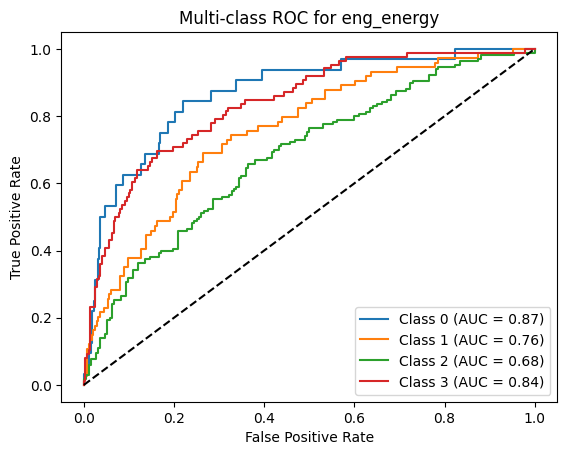

In [15]:
for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    probas = np.mean(Results_XGB_Proba_dict[dimension], axis=0)
    print(probas)

    # Binarize the output
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y_test, classes=np.unique(y_test))
    
    n_classes = y_bin.shape[1]

   # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probas[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC for {dimension}')
    plt.legend(loc="lower right")
    plt.show()

In [32]:
def print_avg_metrics(Results, model_name, dimension, trainerrors=True):
    accuracy_avg = np.mean([res[0] for res in Results[dimension]])
    precision_avg = np.mean([res[1] for res in Results[dimension]])
    recall_avg = np.mean([res[2] for res in Results[dimension]])
    print(f"Model: {model_name} for dimension: {dimension}")
    print(f"Average Accuracy over {montecarloiter} iterations: {accuracy_avg}")
    print(f"Average Precision over {montecarloiter} iterations: {precision_avg}")
    print(f"Average Recall over {montecarloiter} iterations: {recall_avg}")
    
    if trainerrors:
        train_accuracy_avg = np.mean([res[3] for res in Results[dimension]])
        train_precision_avg = np.mean([res[4] for res in Results[dimension]])
        train_recall_avg = np.mean([res[5] for res in Results[dimension]])
        print(f"Average TRAIN Accuracy over {montecarloiter} iterations: {train_accuracy_avg}")
        print(f"Average TRAIN Precision over {montecarloiter} iterations: {train_precision_avg}")
        print(f"Average TRAIN Recall over {montecarloiter} iterations: {train_recall_avg}")
    print("-------------------------------------------------")


for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    print(f"Random classifier for dimension: \"{dimension}\". Average Accuracy over {montecarloiter} iterations: {np.mean(Results_Random_dict[dimension],axis=0)}")
    print(f"Majority classifier for dimension: \"{dimension}\". Average Accuracy over {montecarloiter} iterations: {np.mean(Results_Majority_dict[dimension],axis=0)}")

Random classifier for dimension: "eng_timeflies". Average Accuracy over 1 iterations: 0.3095252957148653
Majority classifier for dimension: "eng_timeflies". Average Accuracy over 1 iterations: 0.388268156424581
Random classifier for dimension: "eng_enthusiastic". Average Accuracy over 1 iterations: 0.30721575481414437
Majority classifier for dimension: "eng_enthusiastic". Average Accuracy over 1 iterations: 0.38268156424581007
Random classifier for dimension: "eng_energy". Average Accuracy over 1 iterations: 0.42114010174463967
Majority classifier for dimension: "eng_energy". Average Accuracy over 1 iterations: 0.48324022346368717


In [33]:
for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    print_avg_metrics(Results_XGB_dict, "XGBoost", dimension)

Model: XGBoost for dimension: eng_timeflies
Average Accuracy over 1 iterations: 0.4581005586592179
Average Precision over 1 iterations: 0.3968675179569034
Average Recall over 1 iterations: 0.4581005586592179
Average TRAIN Accuracy over 1 iterations: 0.552757793764988
Average TRAIN Precision over 1 iterations: 0.6690450567499892
Average TRAIN Recall over 1 iterations: 0.552757793764988
-------------------------------------------------
Model: XGBoost for dimension: eng_enthusiastic
Average Accuracy over 1 iterations: 0.5418994413407822
Average Precision over 1 iterations: 0.543803755913516
Average Recall over 1 iterations: 0.5418994413407822
Average TRAIN Accuracy over 1 iterations: 0.6990407673860911
Average TRAIN Precision over 1 iterations: 0.710110225615935
Average TRAIN Recall over 1 iterations: 0.6990407673860911
-------------------------------------------------
Model: XGBoost for dimension: eng_energy
Average Accuracy over 1 iterations: 0.5446927374301676
Average Precision over 1 

In [34]:
for dimension in ['eng_timeflies', 'eng_enthusiastic', 'eng_energy']:
    print_avg_metrics(Results_LR_dict, "Logistic Regression", dimension)

Model: Logistic Regression for dimension: eng_timeflies
Average Accuracy over 1 iterations: 0.45251396648044695
Average Precision over 1 iterations: 0.4606296907357402
Average Recall over 1 iterations: 0.45251396648044695
Average TRAIN Accuracy over 1 iterations: 0.5179856115107914
Average TRAIN Precision over 1 iterations: 0.531800464264371
Average TRAIN Recall over 1 iterations: 0.5179856115107914
-------------------------------------------------
Model: Logistic Regression for dimension: eng_enthusiastic
Average Accuracy over 1 iterations: 0.5335195530726257
Average Precision over 1 iterations: 0.5489495518563255
Average Recall over 1 iterations: 0.5335195530726257
Average TRAIN Accuracy over 1 iterations: 0.6067146282973621
Average TRAIN Precision over 1 iterations: 0.610413183475531
Average TRAIN Recall over 1 iterations: 0.6067146282973621
-------------------------------------------------
Model: Logistic Regression for dimension: eng_energy
Average Accuracy over 1 iterations: 0.55

In [17]:
print(Xgboost.get_probas())

[[0.16600408 0.21935941 0.41355094 0.20108555]
 [0.16992925 0.2582637  0.38731158 0.18449545]
 [0.15126862 0.2797065  0.40729454 0.16173038]
 ...
 [0.20259489 0.30173832 0.28597328 0.20969348]
 [0.17833993 0.22248355 0.40003175 0.19914478]
 [0.28600413 0.28032392 0.24246404 0.19120793]]


In [18]:
avg_y_proba_xgb = sum(Xgboost.get_probas()) / montecarloiter


In [19]:
avg_y_proba_xgb

array([ 65.89198,  82.87805, 125.54491,  83.68501], dtype=float32)